In [2]:
import os
import torch
from torch.autograd import Variable
from edges2shoes_data import LoaderSampler, load_dataset, tensor2img
from model import AugmentedCycleGAN
import numpy as np

from fid_score import calculate_frechet_distance
from my_utils import get_Z_pushed_loader_stats

import random
import json
from easydict import EasyDict as edict

from torch.utils.tensorboard import SummaryWriter
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

opt = edict({
    'input_nc': 3,
    'output_nc': 3,
    'numpy_data': 0,
    'gpu_ids': ['cuda:2', 'cuda:3'],
    'batchSize': 32,
    'continue_train': False,
    'beta1': 0.5,
    'lr': 0.0002,

    'ngf': 32,
    'nef': 32,
    'ndf': 64,
    'nlatent': 16,
    'which_model_netD': 'basic',
    'which_model_netG': 'resnet',
    'norm': 'instance',
    'use_dropout': True,
    'max_gnorm': 500,
    'stoch_enc': True,
    'z_gan': 1,
    'enc_A_B': 1,

    'no_lsgan': True,
    'lambda_A': 1.0,
    'lambda_B': 1.0,
    'lambda_z_B': 0.025,
    
    "display_freq": 1000,
    
    
    }
)

opt_gpu_ids = [2, 3]
device = f'cuda:{opt_gpu_ids[0]}'

use_gpu = len(opt_gpu_ids) > 0

opt_seed = 0x000000

print("using random seed:", opt_seed)
random.seed(opt_seed)
np.random.seed(opt_seed)
torch.manual_seed(opt_seed)
if use_gpu:
    torch.cuda.manual_seed_all(opt_seed)

DATASET1, DATASET1_PATH = 'handbag', '../../data/handbag_128.hdf5'
DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'

IMG_SIZE = 64

filename = '../stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=opt.batchSize)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=opt.batchSize)

MAX_STEPS = 3000000 // opt.batchSize
OUTPUT_PATH = '../../checkpoints/augmented_cyclegan/{}_{}_{}_{}'.format(DATASET1, DATASET2, IMG_SIZE, MAX_STEPS)
writer = SummaryWriter(os.path.join(OUTPUT_PATH, "tensorboard"))
path_to_save_fig = os.path.join(OUTPUT_PATH, "figs")
if not os.path.exists(path_to_save_fig):
    os.makedirs(path_to_save_fig)

path_to_save_models = os.path.join(OUTPUT_PATH, "models")
if not os.path.exists(path_to_save_models):
    os.makedirs(path_to_save_models)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)

X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

# create_model
model = AugmentedCycleGAN(opt)

# visualizer = Visualizer(opt)
total_steps = 0

print(f"Num batches in train = {len(train_loader_a)}")

using random seed: 0
Keys: KeysView(<HDF5 file "handbag_128.hdf5" (mode r)>)


/home/work/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Keys: KeysView(<HDF5 file "shoes_128.hdf5" (mode r)>)
Num batches in train = 3903


Plotting, iter = 93000
mode = train


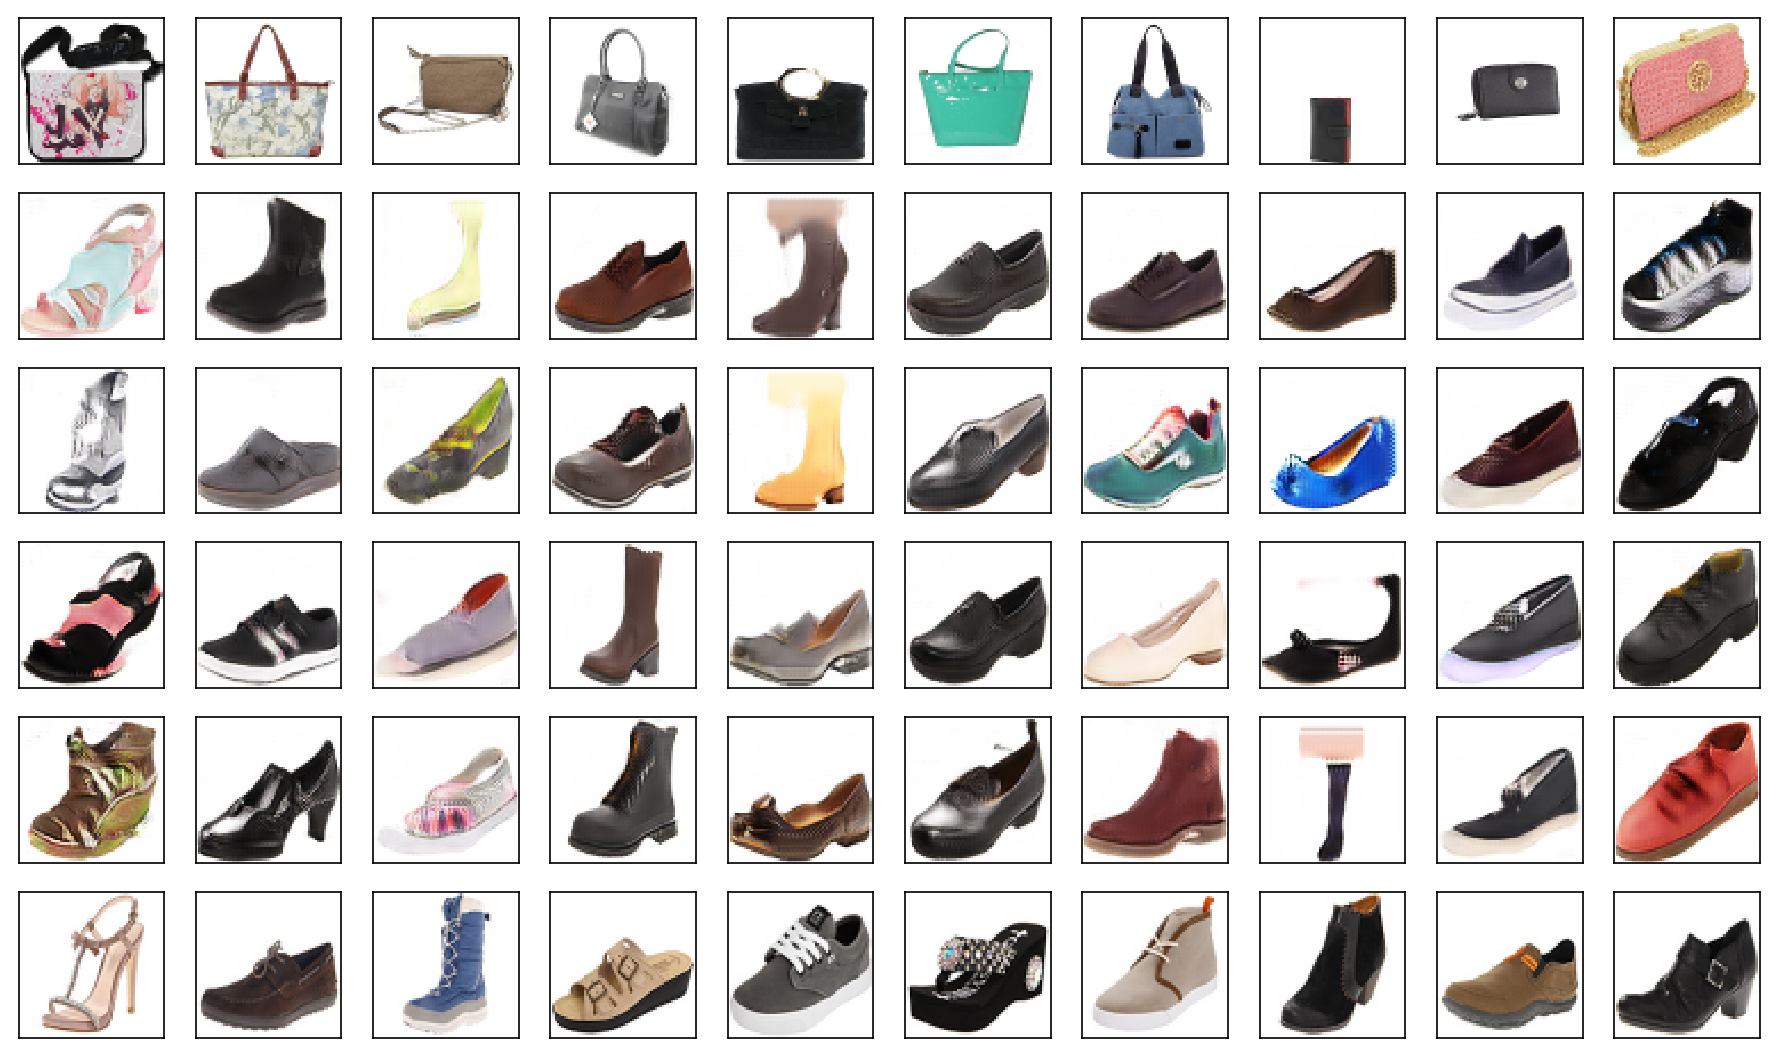

mode = test


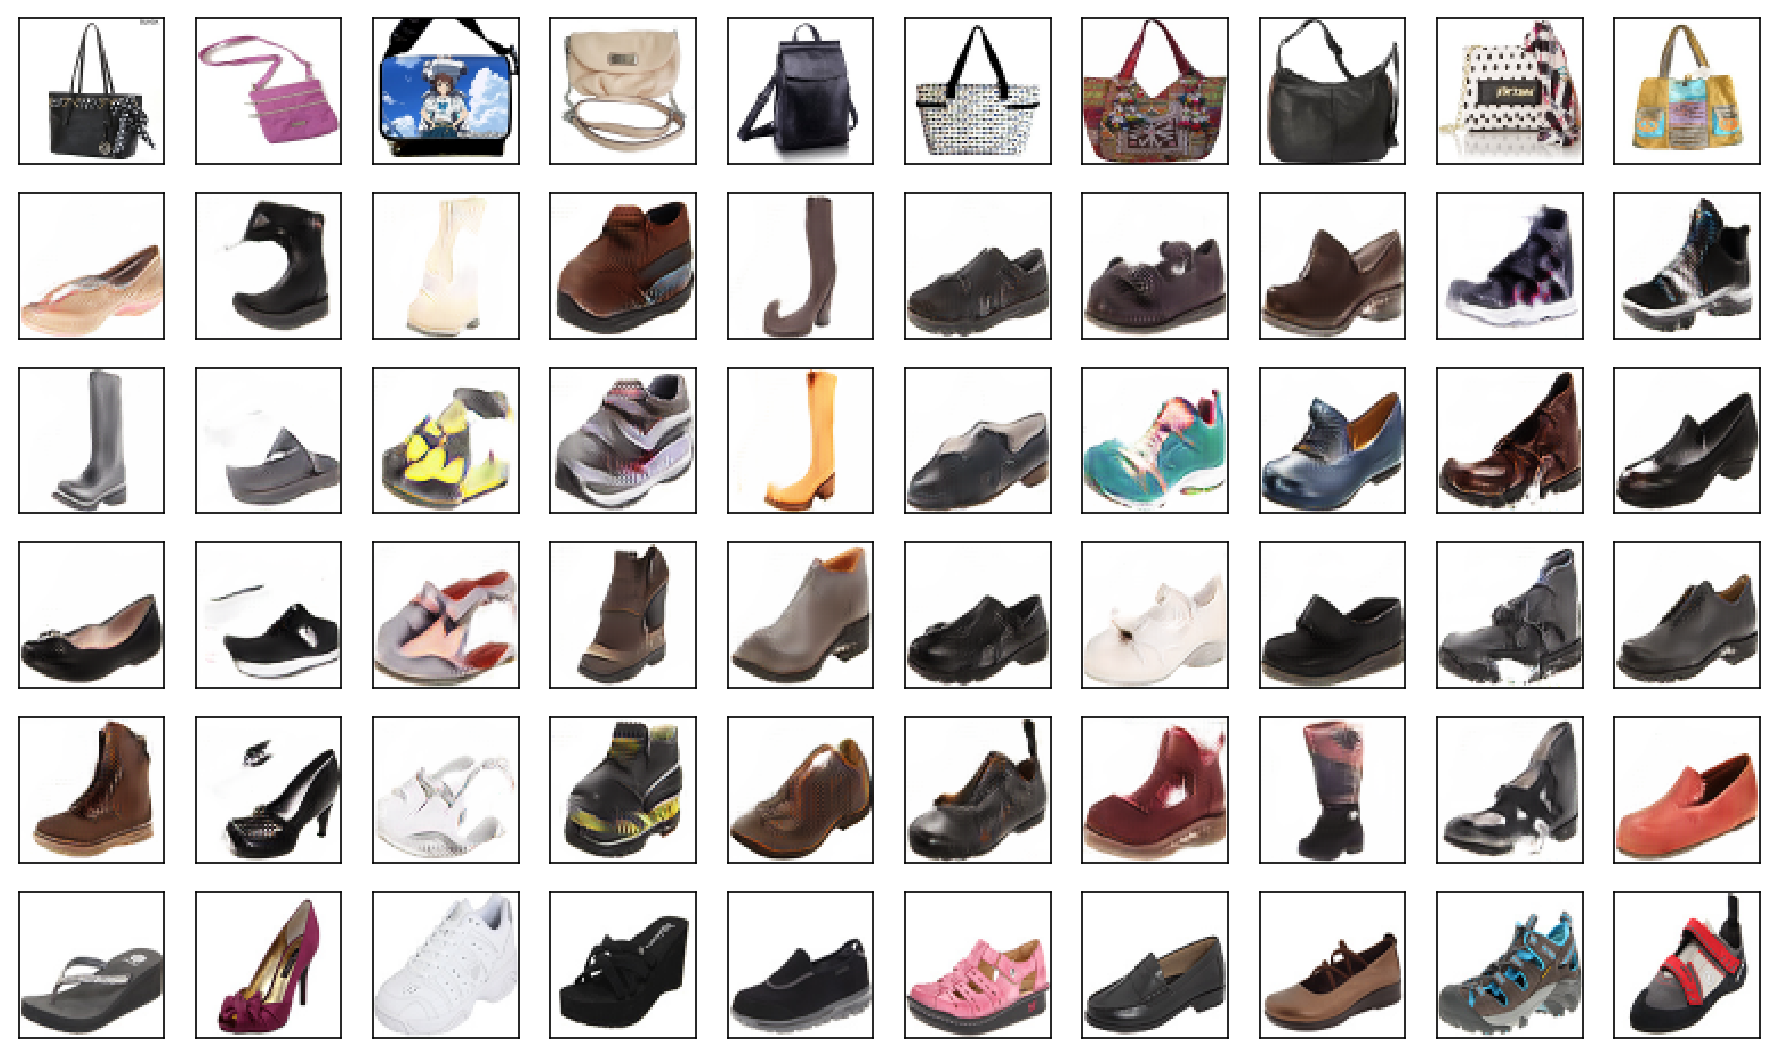

saving model, iter = 93000
Computing FID
FID = 20.14955194802232
it = 93010, loss D_A = 0.2615088224411011
it = 93020, loss D_A = 0.31889110803604126
it = 93030, loss D_A = 0.35269635915756226
it = 93040, loss D_A = 0.24567121267318726
it = 93050, loss D_A = 0.32883620262145996
it = 93060, loss D_A = 0.4557989239692688
it = 93070, loss D_A = 0.27629345655441284
it = 93080, loss D_A = 0.21818017959594727
it = 93090, loss D_A = 0.23376044631004333
it = 93100, loss D_A = 0.3351048529148102
it = 93110, loss D_A = 0.4100703001022339
it = 93120, loss D_A = 0.3807904124259949
it = 93130, loss D_A = 0.2913740277290344
it = 93140, loss D_A = 0.26039403676986694
it = 93150, loss D_A = 0.3113240897655487
it = 93160, loss D_A = 0.2658796012401581
it = 93170, loss D_A = 0.30689334869384766
it = 93180, loss D_A = 0.239220529794693
it = 93190, loss D_A = 0.36676961183547974
it = 93200, loss D_A = 0.30173230171203613
it = 93210, loss D_A = 0.43774816393852234
it = 93220, loss D_A = 0.2283250093460083


In [3]:
opt_niter = 25 * len(train_loader_a)

for it in range(MAX_STEPS):
    epoch_iter = 0

    real_A = Variable(X_sampler.sample(opt.batchSize))
    real_B = Variable(Y_sampler.sample(opt.batchSize))

    prior_z_B = Variable(real_A.data.new(real_A.size(0), opt.nlatent, 1, 1).normal_(0, 1))

    total_steps += opt.batchSize
    epoch_iter += opt.batchSize

    if use_gpu:
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        prior_z_B = prior_z_B.to(device)

    losses, visuals = model.train_instance(real_A, real_B, prior_z_B)
    
    if it % 10 == 0:
        print(f"it = {it}, loss D_A = {losses['D_A']}")

    if it % opt.display_freq == 0:
        clear_output(wait=True)
        
        X_fixed_variable = Variable(X_fixed).to(device)
        X_test_fixed_variable = Variable(X_test_fixed).to(device)

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        model.eval()

        for v in range(num_examples):
            prior_z_B_current = Variable(torch.randn(X_fixed_variable.size(0), opt.nlatent, 1, 1)).to(device)

            fake_Y = model.netG_A_B.forward(X_fixed_variable, prior_z_B_current).detach()
            fake_Y_numpy = tensor2img(fake_Y)
            Y_fakes.append(fake_Y_numpy)

            fake_Y_test = model.netG_A_B.forward(X_test_fixed_variable, prior_z_B_current).detach()
            fake_Y_test_numpy = tensor2img(fake_Y_test)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(X_fixed)
        real_X_test_numpy = tensor2img(X_test_fixed)
        real_Y_numpy = tensor2img(Y_fixed)
        real_Y_test_numpy = tensor2img(Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {it}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for i in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[i][j]

                    axes[i + 1][j].imshow(cur_img)
                    axes[i + 1][j].get_xaxis().set_visible(False)
                    axes[i + 1][j].get_yaxis().set_visible(False)

            
            plt.show(fig)
            writer.add_figure(f'Step {it + 1}, {modes[t]}',
                              fig,
                              global_step=it + 1)
            plt.close(fig)

        model.train()

    if it % opt.display_freq == 0:
        print(f"saving model, iter = {it}")

        model.eval()

        checkpoint = {
            'netG_A_B': model.netG_A_B.state_dict(),
            'netG_B_A': model.netG_B_A.state_dict(),
            'netD_A': model.netD_A.state_dict(),
            'netD_B': model.netD_B.state_dict(),
            'netD_z_B': model.netD_z_B.state_dict(),
            'netE_B': model.netE_B.state_dict(),
            'optimizer_D_A': model.optimizer_D_A.state_dict(),
            'optimizer_G_A': model.optimizer_G_A.state_dict(),
            'optimizer_D_B': model.optimizer_D_B.state_dict(),
            'optimizer_G_B': model.optimizer_G_B.state_dict()
        }

        path_to_save_cur_model = os.path.join(path_to_save_models, f"model_iter_{it}.pth")
        torch.save(checkpoint, path_to_save_cur_model)

        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(model, X_test_sampler.loader, opt, device)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        print(f"FID = {fid}")
        writer.add_scalar('test fid',
                          fid,
                          it + 1)
        del mu, sigma

        model.train()

    if it > opt_niter:
        model.update_learning_rate()